This program creates a convolutional neural network for image recognition


## Import Statements


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
import cv2
from google.colab import drive
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
import io
import zipfile
from google.colab import drive

# Importing Dataset

Link to dataset: https://drive.google.com/drive/folders/1YPuVjC1qK1inVBkVh5teQRVcT8O9wWBH?usp=sharing

You must add a shortcut of Archive.zip to your own drive. This can be done by hitting the "Dataset" dropdown -> Organize -> Add Shortcut -> My Drive. After the shortcut is added, the following imports will work correctly.

In [ ]:
drive.mount('/content/drive/')

# Unzip dataset
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Dataset/dataset.zip", 'r')
zip_ref.extractall("/tmp/dataset")
zip_ref.close()

# Initialize empty lists
X_original = []
Y = []

map_labels ={'buildings' : 0, 'forest' : 1, 'glacier' : 2, 'mountain' : 3, 'sea' : 4, 'street' : 5}

# Define folder path
folder_path = '/tmp/dataset/dataset'

# Check if the folder exists
if os.path.exists(folder_path):
    # Change the current working directory to the "tmp" folder
    os.chdir(folder_path)
else:
    print("The 'tmp' folder does not exist in your Google Drive.")

# Iterate through main folder to define class labels
for label in os.listdir(folder_path):
    label_path = os.path.join(folder_path, label)

    # Iterate through each subfolder and apply class labels
    if os.path.isdir(label_path):
        for image_file in os.listdir(label_path):

            image_path = os.path.join(label_path, image_file)

            img = np.array(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))

            # Reject any images not 150x150 px
            if len(img) != 150: continue

            X_original.append(img)

            # Append the corresponding label (folder name) to Y_train list
            Y.append(map_labels[label])

# Convert to numpy arrays
X_original = np.array(X_original)
Y = np.array(Y)


Mounted at /content/drive/


(150, 150, 3)
3


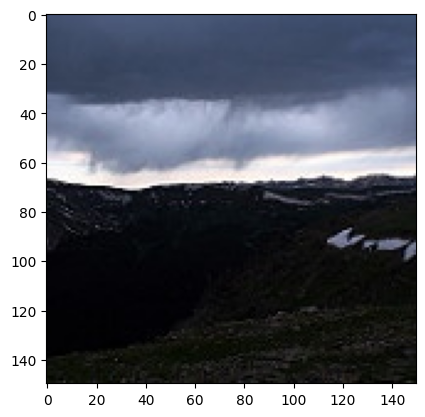

In [ ]:
# Example of a picture
index = 1000
plt.imshow(X_original[index])
print(X_original[index].shape)
print(Y[index])

# Convolution Layer Definition

The architecture of a standard convolutional layer uses square kernels or filters and a ReLu activation function on the output feature map to introduce non-linearity to the network.

In [ ]:
class ConvolutionalLayer:

    def __init__(self, num_filters, filter_size, stride, padding, input_channels):
        self.num_filters = num_filters
        self.filter_size = filter_size  # We assume a square filter
        self.stride = stride
        self.padding = padding
        self.input_channels = input_channels

        # Create random filters with constant normalization
        self.filters = np.random.randn(num_filters, filter_size, filter_size, input_channels) / (filter_size ** 2)
        self.biases = np.random.randn(1, num_filters) / (filter_size ** 2)

    def forward_pass(self, input_image):
        # Calculate output_feature_map dimensions
        input_height, input_width, _ = input_image.shape
        output_height = (input_height - self.filter_size + 2 * self.padding) // self.stride + 1
        output_width = (input_width - self.filter_size + 2 * self.padding) // self.stride + 1

        # Initialize empty output_feature_map to store results of convolution operations
        output_feature_map = np.zeros((output_height, output_width, self.num_filters))

        # Pad image to avoid losing
        self.padded_input_image = np.pad(input_image, ((self.padding, self.padding), (self.padding, self.padding), (0, 0)), mode='constant')

        # Convolve through each of the filters and the dimensions of the padded input image
        for f in range(self.num_filters):
            for h in range(output_height):
                for w in range(output_width):
                    # Determine the coordinates of the receptive field
                    h_start = h * self.stride
                    h_end = h_start + self.filter_size
                    w_start = w * self.stride
                    w_end = w_start + self.filter_size

                    # Calculates the dotproduct of the receptive field with the current filter
                    receptive_field = self.padded_input_image[h_start:h_end, w_start:w_end, :]
                    output_feature_map[h, w, f] = np.sum(receptive_field * self.filters[f]) + self.biases[0, f]

        return output_feature_map

    def backward_pass(self, deriv_wrt_output, learning_rate):
        # Initialize volume for gradients with respect to the input image with padding
        output_height, output_width, _ = deriv_wrt_output.shape
        deriv_wrt_padded_input = np.zeros((output_height + 2 * self.padding, output_width + 2 * self.padding, self.input_channels))

        # Gradient clipping
        max_grad_norm = 1.0  # Define a maximum gradient norm
        grad_norm = np.linalg.norm(deriv_wrt_padded_input)
        if grad_norm > max_grad_norm:
            scale_factor = max_grad_norm / grad_norm
            deriv_wrt_padded_input *= scale_factor

        # Convolve through each of the filters with the gradients wrt to the output image
        for f in range(self.num_filters):
            for h in range(output_height):
                for w in range(output_width):
                    # Determine the coordinates of the receptive field
                    h_start = h * self.stride
                    h_end = h_start + self.filter_size
                    w_start = w * self.stride
                    w_end = w_start + self.filter_size

                    # Calculate and accumulate the gradient contribution of each input element by convolution of the input image with the loss gradient wrt the output
                    deriv_wrt_padded_input[h_start:h_end, w_start:w_end, :] += deriv_wrt_output[h, w, f] * self.filters[f]

                    # Calculate the gradient contribution of each filter element by convolution of the input image with the loss gradient wrt the output and update weights
                    self.filters[f] -= learning_rate * np.sum(deriv_wrt_output[h, w, f] * self.padded_input_image[h_start:h_end, w_start:w_end, :], axis=(0, 1, 2))
                    self.biases[0, f] -= learning_rate * deriv_wrt_output[h, w, f]


        # Remove the padding to get gradients for the actual input image
        if self.padding > 0:
            deriv_wrt_input = deriv_wrt_padded_input[self.padding:-self.padding, self.padding:-self.padding, :]
        else:
            deriv_wrt_input = deriv_wrt_padded_input

        return deriv_wrt_input


# ReLu Layer

In [ ]:
class ReLuLayer:

    def __init__(self):
        self.image = None

    def forward_pass(self, image):
        self.image = image
        # Apply ReLU activation function to the output feature map
        return np.maximum(0, image)

    def backward_pass(self, deriv_wrt_output):
        # Backpropagate gradients through ReLU
        deriv_wrt_input = deriv_wrt_output * (self.image > 0)
        return deriv_wrt_input

# Max Pooling Layer

Note that a pool_size= 2 and stride= 2 will halve the dimensionality of an input image. For example, 150x150x3 will become a 75x75x3.

In [ ]:
class MaxPoolingLayer:

    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size  # We assume a square pooling filter
        self.stride = stride

    def forward_pass(self, input_image):
        # Calculate output_feature_map dimensions
        input_height, input_width, num_channels = input_image.shape
        output_height = (input_height - self.pool_size) // self.stride + 1
        output_width = (input_width - self.pool_size) // self.stride + 1
        self.image = input_image

        # Initialize the empty output_feature_map to store result
        output_feature_map = np.zeros((output_height, output_width, num_channels))

        # Iterate over each pooling region in each channel
        for c in range(num_channels):
            for h in range(output_height):
                for w in range(output_width):
                    # Determine the coordinates of the pooling region
                    h_start = h * self.stride
                    h_end = h_start + self.pool_size
                    w_start = w * self.stride
                    w_end = w_start + self.pool_size

                    # Extract the pooling region from the input image
                    pooling_region = input_image[h_start:h_end, w_start:w_end, c]

                    # Apply max pooling to get the maximum value within the pooling region
                    output_feature_map[h, w, c] = np.max(pooling_region)

        return output_feature_map

    def backward_pass(self, deriv_wrt_output):
        # Initialize volume for gradients with respect to the input image
        input_height, input_width, num_channels = self.image.shape
        output_height, output_width, _ = deriv_wrt_output.shape
        deriv_wrt_input = np.zeros_like(self.image)

        # Loop over each channel and each coordinate in the output feature map, which corresponds to a pooling region in the input feature map
        for c in range(num_channels):
            for h in range(output_height):
                for w in range(output_width):
                    # Determine the coordinates of the pooling region
                    h_start = h * self.stride
                    h_end = h_start + self.pool_size
                    w_start = w * self.stride
                    w_end = w_start + self.pool_size

                    # Extract the local region from the input feature map corresponding to the coordinate in the output feature map (h, w)
                    local_region = self.image[h_start:h_end, w_start:w_end, c]

                    # Find the h, w coordinates of the maximum value in the local region
                    max_pos = np.unravel_index(np.argmax(local_region), local_region.shape)

                    # Distribute the gradients to the corresponding position in the input feature map; Every other position does not change
                    deriv_wrt_input[h_start + max_pos[0], w_start + max_pos[1], c] = deriv_wrt_output[h, w, c]

        return deriv_wrt_input

# Flatten Layer


In [ ]:
class FlattenLayer:
    def __init__(self):
        self.input_shape = None

    def forward_pass(self, input_data):
        self.input_shape = input_data.shape
        flattened_output = input_data.reshape(-1)
        return flattened_output

    def backward_pass(self, d_output_data):
        return d_output_data.reshape(self.input_shape)

# Fully Connected Layer Relu

In [ ]:
class FullyConnectedLayerReLu:

    def __init__(self, input_size, output_size):
        self.input_size = input_size                # Number of input features (flattened)
        self.output_size = output_size              # Number of neurons in the layer for classification.

        # Initialize weights and biases with random values
        self.weights = np.random.randn(output_size, input_size) * 0.01
        self.biases = np.random.randn(output_size) * 0.01

    def forward_pass(self, input):
        self.input = input

        # Calculate raw output net
        self.output = np.dot(self.weights, input) + self.biases

        # Remember positions where net > 0
        self.relu_mask = self.output > 0

        # Perform ReLu
        self.pred = np.maximum(0, self.output)

        return self.pred

    def backward_pass(self, deriv_wrt_output, learning_rate):
        # Calculate derivatives wrt to net, weight, inputs. D_wrt_bias = deriv_wrt_net
        self.deriv_wrt_net = self.relu_mask * deriv_wrt_output.T
        self.deriv_wrt_weight = (self.deriv_wrt_net.reshape(-1, 1) * self.input)
        self.deriv_wrt_inputs = np.dot(self.weights.T, self.deriv_wrt_net.T)

        # Update weights and biases using the gradients
        self.weights -= learning_rate * self.deriv_wrt_weight
        self.biases -= learning_rate * self.deriv_wrt_net

        return self.deriv_wrt_inputs

    def relu_derivative(self, x):
        return (x > 0).astype(int)


# Fully Connected Layer SoftMax

In [ ]:
class FullyConnectedLayerSoftMax:

    def __init__(self, input_size, output_size):
        self.input_size = input_size         # Number of input features (flattened)
        self.output_size = output_size       # Number of neurons in the layer for classification.

        # Initialize weights and biases with random values
        self.weights = np.random.randn(output_size, input_size) * 0.01
        self.biases = np.random.randn(output_size) * 0.01

    def forward_pass(self, input):
        self.input = input

        # Calculate raw output
        self.output = np.dot(self.weights,self.input) + self.biases

        # Perform softmax
        self.pred = self.soft_max(self.output)

        return self.pred

    def backward_pass(self, gradient, learning_rate):
        # Calculate derivatives wrt to net, weight, inputs. D_wrt_bias = deriv_wrt_net
        self.deriv_wrt_net = gradient
        self.deriv_wrt_weights = self.deriv_wrt_net.reshape(-1, 1) * self.input
        self.deriv_wrt_inputs = np.dot(self.weights.T, self.deriv_wrt_net)

        # Gradient clipping
        max_grad_norm = 1.0  # Define a maximum gradient norm
        grad_norm = np.linalg.norm(self.deriv_wrt_weights)  # Compute gradient norm
        if grad_norm > max_grad_norm:
            scale_factor = max_grad_norm / grad_norm
            self.deriv_wrt_weights *= scale_factor
            self.deriv_wrt_net *= scale_factor

        # Update the weights and biases using gradient descent
        self.weights -= learning_rate * self.deriv_wrt_weights
        self.biases -= learning_rate * self.deriv_wrt_net

        return self.deriv_wrt_inputs

    def soft_max(self, raw_output):
        exponential = np.exp(raw_output)
        softmax_output = exponential / np.sum(exponential)
        return softmax_output

    def cross_entropy(self, true_labels_one_hot):
        # Compute the negative log likelihood of the true class probabilities and sum them
        loss = -np.sum(true_labels_one_hot * np.log(self.pred + 1e-10))
        return loss

# Notes

We use a Softmax Activation Function as opposed to Sigmoid or Tanh since it is better for multi-class classification problems, where the goal is to assign a probability distribution over multiple classes for each input sample.

Loss function is Cross-entropy loss since it performs well with multi-class classification tasks.

# Calls to Methods

## Full Forward Pass


In [ ]:
def full_forward_pass(input, layers):
  # Scale output between 0 and 1
  output = input/255
  # Pass output of forward prop to next layer
  for layer in layers:
        output = layer.forward_pass(output)
  return output


## Full Backward Pass

In [ ]:
def full_backward_pass(gradient, layers, learning_rate = 0.05):
  grade = gradient
  # Go backwards through layers
  for layer in layers[::-1]:
      # If layer is conv or so fullyconnected pass learnrate
      if type(layer) == ConvolutionalLayer or type(layer) == FullyConnectedLayerSoftMax or type(layer) == FullyConnectedLayerReLu:
          grade = layer.backward_pass(grade, learning_rate)
      else:
          grade = layer.backward_pass(grade)
  return grade

## Full Epoch

In [ ]:
def run_epoch(input, label, layers, learning_rate=0.05):
    # Forward step
    output = full_forward_pass(input, layers)
    one_hot_labels = index_to_one_hot(label, 6)

    # Initial gradient
    gradient = output - np.array(one_hot_labels)

    # Calculate loss
    loss = layers[-1].cross_entropy(one_hot_labels)

    # Backprop step
    gradient_back = full_backward_pass(gradient, layers, learning_rate)

    return loss, output

def index_to_one_hot(index, array_size):
  one_hot_encoding = [0] * array_size
  one_hot_encoding[index] = 1
  return one_hot_encoding

## Testing Model

In [ ]:
def test_model(X_test, Y_test, layers):

    Y_pred = []
    avg_loss = 0
    total_loss = 0

    for i, (image, label) in enumerate(zip(X_test, Y_test)):
        # Forward pass
        output = full_forward_pass(image, layers)
        Y_pred.append(np.argmax(output, axis = None))

        # Accumulate total loss
        one_hot_labels = index_to_one_hot(label, 6)
        total_loss += layers[-1].cross_entropy(one_hot_labels)

        if i % 20 == 0:
            print("Iteration", i)

    avg_loss = total_loss / len(Y_test)

    return Y_pred, avg_loss

# Main


In [ ]:
# Test Train Split
X_train, X_test, Y_train, Y_test = train_test_split(X_original, Y, test_size = .2, random_state=40)

# Define model layers
layers = [

    # MaxPoolingLayer(pool_size= 3, stride=3),
    # ConvolutionalLayer2(num_filters = 3,
    #                       filter_size = 3,
    #                       stride = 1,
    #                       padding = 1,
    #                       input_channels = 3),
    # ReLuLayer(),
    # ConvolutionalLayer2(num_filters = 3,
    #                       filter_size = 3,
    #                       stride = 1,
    #                       padding = 1,
    #                       input_channels = 1),
    # ReLuLayer(),
    MaxPoolingLayer(pool_size= 2, stride=2),
    FlattenLayer(),
    FullyConnectedLayerReLu(input_size= 16875, output_size= 7500),
    FullyConnectedLayerReLu(input_size= 7500, output_size= 3000),
    FullyConnectedLayerReLu(input_size= 3000, output_size= 1000),
    FullyConnectedLayerReLu(input_size= 1000, output_size= 500),
    FullyConnectedLayerSoftMax(input_size= 500, output_size = 6),
    ]

num_correct = 0
num_pred = 0
loss_sum = 0
avg_loss = None

# Train Model
for epoch in range(1):
  for i, (image, label) in enumerate(zip(X_train, Y_train)):
    loss, output = run_epoch(image, label, layers, learning_rate=0.01)

    # Track results
    prediction = np.argmax(output, axis = None)
    num_pred += 1
    if label == prediction:
        num_correct += 1

    accuracy = round(num_correct / num_pred, 3)
    loss_sum += loss

    if i % 50 == 0:
        print("Iteration", i)

avg_loss = loss_sum / len(Y_train)
print("Avg_Training_Loss= ", round(avg_loss, 3), "Avg_Training_Accuracy= ", accuracy)

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500
Iteration 550
Iteration 600
Iteration 650
Iteration 700
Iteration 750
Iteration 800
Iteration 850
Iteration 900
Iteration 950
Iteration 1000
Iteration 1050
Iteration 1100
Iteration 1150
Iteration 1200
Iteration 1250
Iteration 1300
Iteration 1350
Iteration 1400
Iteration 1450
Iteration 1500
Iteration 1550
Iteration 1600
Iteration 1650
Iteration 1700
Iteration 1750
Iteration 1800
Iteration 1850
Iteration 1900
Iteration 1950
Iteration 2000
Iteration 2050
Iteration 2100
Iteration 2150
Iteration 2200
Iteration 2250
Iteration 2300
Iteration 2350
Iteration 2400
Iteration 2450
Iteration 2500
Iteration 2550
Iteration 2600
Iteration 2650
Iteration 2700
Iteration 2750
Iteration 2800
Iteration 2850
Iteration 2900
Iteration 2950
Iteration 3000
Iteration 3050
Iteration 3100
Iteration 3150
Iteration 3200
Iteration 3250
Iteration 3300
Iteration 3350
Ite

In [ ]:
# Test Model
Y_pred, test_avg_loss  = test_model(X_test, Y_test, layers)

Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Iteration 500
Iteration 520
Iteration 540
Iteration 560
Iteration 580
Iteration 600
Iteration 620
Iteration 640
Iteration 660
Iteration 680
Iteration 700
Iteration 720
Iteration 740
Iteration 760
Iteration 780
Iteration 800
Iteration 820
Iteration 840
Iteration 860
Iteration 880
Iteration 900
Iteration 920
Iteration 940
Iteration 960
Iteration 980
Iteration 1000
Iteration 1020
Iteration 1040
Iteration 1060
Iteration 1080
Iteration 1100
Iteration 1120
Iteration 1140
Iteration 1160
Iteration 1180
Iteration 1200
Iteration 1220
Iteration 1240
Iteration 1260
Iteration 1280
Iteration 1300
Iteration 1320
Iteration 1340
Iteration 1360
Iteration 1380
Iterat

[0.20335459 0.11541891 0.11984813 0.11343893 0.17179796 0.27614149]
Guess:  street
Actual:  street


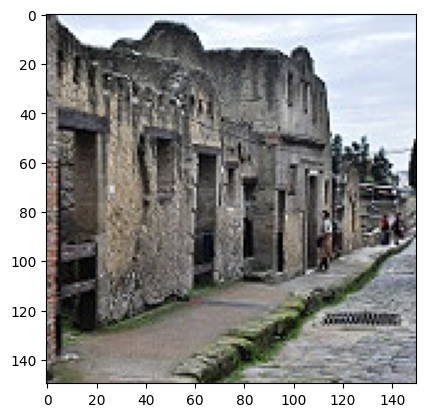

In [ ]:
# Test a specific sample
testnum = 30
output = full_forward_pass(X_test[testnum], layers)
arr = ['buildings' , 'forest' , 'glacier' , 'mountain' , 'sea', 'street']
print(output)
print("Guess: ", arr[np.argmax(output, axis = None)])
print("Actual: ", arr[Y_test[testnum]])
plt.imshow(X_test[testnum])

## Output Metrics

Testing Statistics
_________________________________________
Test Accuracy: 0.42659
Test Precision: 0.47134
Test Recall: 0.41547
Test F1: 0.38373
Average Test Loss: 1.445397093792606


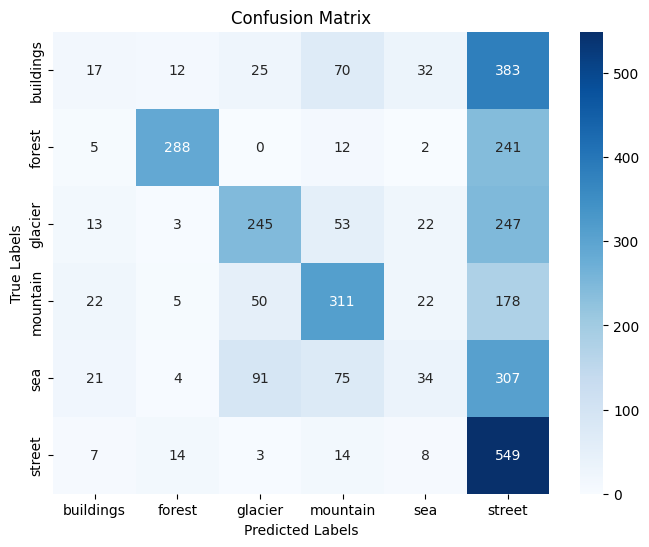

In [ ]:
# Get the unique labels from the data
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))
label_names = ['buildings' , 'forest' , 'glacier' , 'mountain' , 'sea', 'street']

# Calculate test statistics
test_accuracy = round(accuracy_score(Y_test, Y_pred), 5)
test_precision = round(precision_score(Y_test, Y_pred, average = 'macro'), 5)
test_recall = round(recall_score(Y_test, Y_pred, average = 'macro'), 5)
test_f1 = round(f1_score(Y_test, Y_pred, average = 'macro'), 5)
cm = confusion_matrix(Y_test, Y_pred)

print("Testing Statistics")
print("_________________________________________")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1:",test_f1)
print("Average Test Loss:", test_avg_loss)

# Create the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()